```{index} single: solver; cbc
```
```{index} pandas dataframe
```
```{index} sample average approximation
```
```{index} stochastic optimization
```
```{index} chance constraints
```
```{index} mutable parameters
```

# Economic dispatch in energy systems

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook.

If run on Google Colab, the cell installs Pyomo and the ipopt solver via the IDEAS repository, then sets SOLVER to 
use the ipopt solver. If run elsewhere, it assumes Pyomo and the Mosek solver
have been previously installed and sets SOLVER to use the Mosek solver via the Pyomo 
SolverFactory. It then verifies that SOLVER is available.

In [1]:
import sys
import os

SOLVER = "mosek_direct"

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    
    SOLVER = "ipopt"

from pyomo.environ import SolverFactory
assert SolverFactory(SOLVER).available(), f"Solver {SOLVER} is not available."

# Chance-constrained economic energy dispatch problem

In this notebook, we will explore the applications of chance constraints to an area where high-probability guarantees on the system's functioning are required - the _economic dispatch (ED)_ problem.

The problem considers the short-term determination of the optimal production of energy to meet all energy demands. Let $V$ denote a set of nodes, each of which is representing cities, industrial districts, power generators, or combinations of these. Each node $i \in V$ may have:
- a certain energy demand $d_i \geq 0$; 
- a power generator whose energy production needs to be between $p_i^{min}$ and $p_i^{max}$ units of power. The cost of producing one unit of power at node $i$ is given by a variable cost $c_i \geq 0$. 
Importantly, not all the nodes have demand and generation, more specifically it is possible for a node to have only generation or only demand.

The goal is to determine for each node $i \in V$ the optimal production level $p_i$, such that 
- the total energy demand is met
- no production limits are exceeded
- the total energy production costs are minimized. 

If we fully control the energy production and the customer demand is known, can formulate the problem as the following MILO problem:

$$
\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i p_i\\
\text{s.t.} & \sum_{i \in V} p_i = \sum_{i \in V} d_i,\\
& p_{i}^{min} \leq p_{i} \leq p_{i}^{max} & \forall i \in V.
\end{array}
\end{align}
$$

Now, assume that we have built several offshore wind turbines. These wind turbines combined together produce a random non-negative amount of extra energy, denoted by $\omega$. For a fixed value of $\omega$, the optimization problem to be solved is thus to 'fill in' to the remaining energy demand not satisfied by wind power:

$$
\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i p_i\\
\text{s.t.} & \omega + \sum_{i \in V} p_i = \sum_{i \in V} d_i,\\
& p_{i}^{min} \leq p_{i} \leq p_{i}^{max} & \forall i \in V.
\end{array}
\end{align}
$$

The problem, however, is that $\omega$ is a random variable and is typically not fully known before the generation levels $p_i$ of conventional generators have to be set. Because of stochastic fluctuations in wind power generation, the ED problem is best modeled as a stochastic optimization problem. The intermittency of wind generation makes it almost impossible to perfectly balance supply and demand on a real-time basis, but in practice there is some tolerance for error, i.e., certain degree of mismatch between supply and demand can be easily adjusted for. 

To formulate the problem under this assumption, let us denote by:
- $\Delta \geq 0$ the tolerance of the absolute power mismatch between supply and demand;
- $\varepsilon \in [0,1]$ is the risk level at which we are willing to accept for the supply to deviate from the demand more than $\Delta$;
- $\omega$ the non-negative random variable describing the total power production of offshore wind turbines.

In this setting, instead of requiring that the supply and demand are matched perfectly, we require that the absolute difference remains below power threshold $\Delta$ using the following chance constraint:

$$
\begin{align}
  \mathbb{P} \Big ( \Big | \omega + \sum_{i \in V } p_i  - \sum_{i \in V} d_i \Big | \leq \Delta \Big) \geq 1 - \varepsilon.
\end{align}
$$

To formulate the problem as an MILO, we can break up this absolute-value function including constraint into two individual chance constraints - note that in this way we relax the constraint because requiring that two one-sided constraints hold with probability $1 - \varepsilon$ each is not the same as requiring that together they hold with probability $1 - \varepsilon$, but in practice we can fine-tune the $\varepsilon$ to adapt for this change.

Such breaking up leads us to the following optimization problem with chance constraints:

$$
\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V } c_i p_i\\
\text{s.t.} & \mathbb{P}(\omega + \sum_{i \in V } p_i  - \sum_{i \in V} d_i \leq \Delta) \geq 1 - \varepsilon\\
& \mathbb{P}(\omega + \sum_{i \in V } p_i  - \sum_{i \in V} d_i \geq -\Delta) \geq 1 - \varepsilon\\
& p_{i}^{min } \leq p_{i} \leq p_{i}^{max } & \forall i \in V.
\end{array}
\end{align}
$$

In this notebook, we will solve this problem using the SAA approach to chance constraints, with the wind power production using modeled with historical data of 500 outcomes of the total wind production.

## Data import

We first import the necessary packages and define a function that reads all the necessary node and wind production random sample data.

In [2]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def read_economic_dispatch_data():
    base_url = "https://raw.githubusercontent.com/mobook/MO-book/main/notebooks/09/"
    nodes_df = pd.read_csv(base_url + "nodes.csv", index_col=0)[["node_id", "d", "p_min", "p_max", "c_var"]]

    wind_production_samples_df = pd.read_csv(base_url + "discrete_wind.csv").T

    # Read data
    nodes = nodes_df.set_index("node_id").T.to_dict()
    wind_production_samples = list(
        wind_production_samples_df.to_dict().values()
    )
    wind_production_samples = [sum(d.values()) for d in wind_production_samples]

    return nodes, wind_production_samples


nodes, wind_production_samples = read_economic_dispatch_data()

The wind production samples can be accessed through the `wind_production_samples` variable - a list of 500 equiprobable outcomes for the wind generation.

In [4]:
wind_production_samples[4]  # fifth outcome

196.94632359541376

Let us take a look into the wind production data, including a Kernel Density Estimate. 
We see that is has two modes. 
This [paper](https://link.springer.com/article/10.1007/s40565-015-0172-5) explains what one could do with this.

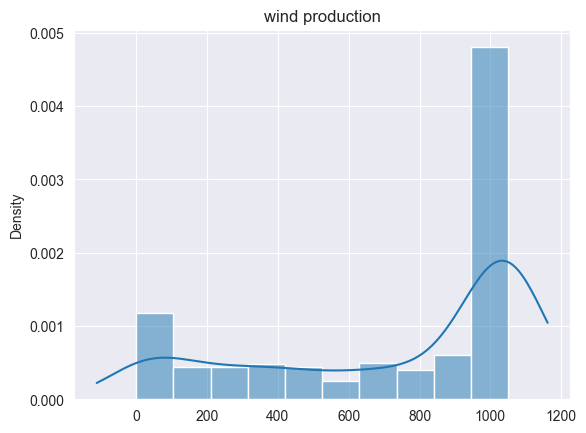

In [5]:
sns.set_style("darkgrid")
sns.histplot(
    wind_production_samples, kde=True, stat="density", kde_kws=dict(cut=1)
).set_title("wind production")
plt.show()

The `nodes` dictionary contains for every $i \in V$ information about $p_i^{min}$, $p_i^{max}$, $c_i$, $d_i$. In our dataset, there is a clear separation of the nodes into nodes that only consume power, and nodes that only produce power, which can be seen by inspecting the node properties.

In [6]:
nodes[0]  # first node properties

{'d': 44.23034433319671, 'p_min': 0.0, 'p_max': 0.0, 'c_var': 0.0}

Let us now provide some locations to our producers and consumers and visualize the data, using bubbles proportional to the size of demand (for consumers) and maximum generation capacity (for producers).

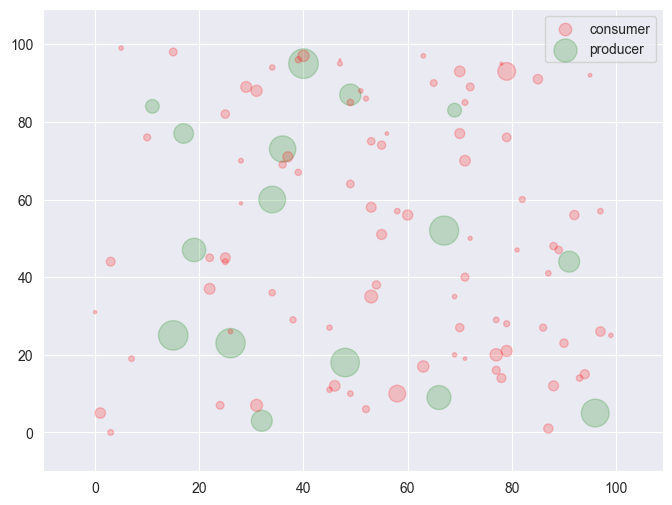

In [7]:
df_nodes = pd.DataFrame.from_dict(nodes, orient="index")
df_nodes["type"] = "consumer"
df_nodes.loc[df_nodes.p_max > 0, "type"] = "producer"
np.random.seed(2023)
df_nodes["x"] = np.random.randint(0, 100, len(nodes))
df_nodes["y"] = np.random.randint(0, 100, len(nodes))
df_nodes["size"] = df_nodes[["d", "p_max"]].max(axis=1)


def ShowInstance(df_nodes):
    # Define the size of the figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Set the scales of the x and y axes
    ax.set_xlim([min(df_nodes["x"]) - 10, max(df_nodes["x"]) + 10])
    ax.set_ylim([min(df_nodes["y"]) - 10, max(df_nodes["y"]) + 10])

    # Create a scatter plot with bubbles proportional to size
    # ax.scatter(df_nodes['x'], df_nodes['y'], s=df_nodes['size']*1)
    for (category, group), z, color in zip(
        df_nodes.groupby("type"), [2, 1], ["red", "green"]
    ):
        ax.scatter(
            group.x,
            group.y,
            s=group["size"] * 1,
            label=category,
            alpha=0.2,
            zorder=z,
            color=color,
        )
        if "sol" in group:
            ax.scatter(
                group.x,
                group.y,
                s=group["sol"] * 1,
                label=None,
                alpha=1,
                zorder=z,
                color=color,
            )

    plt.legend()
    # Show the chart
    plt.show()


ShowInstance(df_nodes)

## MILO reformulation for the chance-constrained ED problem

Since we have a discrete set of $N$ possible wind production outcomes, we can reformulate the chance-constrained ED problem as a mixed-integer linear optimization problem. More specifically, we introduce a binary variable $u_j$ for each sample $j$ of the wind production, which, thanks to the big-$M$ technique, determines whether the constraint related to the $j$-th sample is allowed to be violated or not, and add one constraint to ensure that the total probability that the constraint is violated is at most $\varepsilon$, i.e.,

$$
\frac{1}{N} \sum_{j=1}^{N} u_j \leq \varepsilon.
$$

The resulting MILO is

$$
\begin{align}
\begin{array}{llll}
\min        & \sum_{i \in V} c_i(p_i)\\
\text{s.t.} & \omega_j + \sum_{i \in V} p_i  - \sum_{i \in V} d_i \leq \Delta + u_jM_j & \forall j = 1, \dots, N\\
&  \omega_j + \sum_{i \in V} p_i  - \sum_{i \in V} d_i \geq -\Delta - u_jM_j & \forall j = 1, \dots, N\\
& \sum_{j=1}^{N}u_j \leq \varepsilon N \\
& p_{i}^{min } \leq p_{i} \leq p_{i}^{max } & \forall i \in V, \\
& u_j \in \{0, 1\} & \forall j = 1, ..., N,
\end{array}
\end{align}
$$

For each sample, the supply and demand constraints are deactivated when $u_j =1$ and $u_j=0$ otherwise. Note that we only use one single $u_j$ variable for each constraint. Indeed, having two separate $u^{(1)}_j$ and $u^{(2)}_j$ will yield the same objective value, but the model would be incorrect with respect to the violation of the supply and demand constraints introduced earlier. 

The constants $M_j$'s here should be selected based on the data: one reasonable choice for $M_j$ that will certainly work out is to take it equal to the left-hand side minus $\Delta$ while replacing $p_i$ for $p_i^{max}$.

We now define the Python function which implements this model. Note that the model is formulated with $\varepsilon$ and $\Delta$ as mutable model parameters, so that we can repeatedly solve the same model instance, upon modifying the parameters. In turn, this requires the $M_j$ constants to be expressions.

In [8]:
def economic_dispatch(nodes, samples, eps, Delta):
    
    model = pyo.ConcreteModel("Economic Dispatch")

    model.n = pyo.Param(mutable=False, initialize=len(samples))
    model.eps = pyo.Param(mutable=True, initialize=eps)
    model.Delta = pyo.Param(mutable=True, initialize=Delta)

    model.N = pyo.Set(initialize=range(model.n()))
    model.nodes = pyo.Set(initialize=nodes.keys())

    @model.Expression(model.N)
    def M(model, j):
        return (
            samples[j]
            + sum(data["p_max"] for _, data in nodes.items())
            + sum(data["d"] for _, data in nodes.items())
            - model.Delta
        )

    model.p = pyo.Var(nodes, domain=pyo.NonNegativeReals, bounds=lambda m, i: (nodes[i]["p_min"], nodes[i]["p_max"]))
    model.u = pyo.Var(model.N, domain=pyo.Binary)

    @model.Objective(sense=pyo.minimize)
    def objective(m):
        return sum(data["c_var"] * m.p[i] for i, data in nodes.items())

    @model.Constraint(model.N)
    def supply_demand_leq(m, j):
        wind = samples[j]
        supply = sum(m.p[i] for i, data in nodes.items())
        demand = sum(data["d"] for _, data in nodes.items())
        return wind + supply - demand <= model.Delta + model.M[j] * m.u[j]

    @model.Constraint(model.N)
    def supply_demand_geq(m, j):
        wind = samples[j]
        supply = sum(m.p[i] for i, data in nodes.items())
        demand = sum(data["d"] for _, data in nodes.items())
        return wind + supply - demand >= -model.Delta - model.M[j] * m.u[j]

    @model.Constraint()
    def success_probability(m):
        return sum(m.u[j] for j in model.N) <= model.eps * model.n

    return model

For demonstration purposes, we now solve the model for the provided instance and wind production outcomes and report the optimal objective value you obtain for $\varepsilon = 0.02$ and $\Delta=1000$.

In [9]:
# Data
eps = 0.20
Delta = 1000
N = 500

# Solve model and report the solution
model = economic_dispatch(nodes, wind_production_samples, eps, Delta)
result = pyo.SolverFactory(SOLVER).solve(model)
sum_production = sum([model.p[x].value for x in model.p])
sum_demand = sum(data["d"] for i, data in nodes.items())
print(f"Total energy demand: {sum_demand:.3f}")
print(f"Total optimal energy production: {sum_production:.3f}")
print(f"Total energy production cost: {model.objective():.3f}")

Total energy demand: 3007.112
Total optimal energy production: 1733.393
Total energy production cost: 7850.601


# Visualizing and understanding the solution

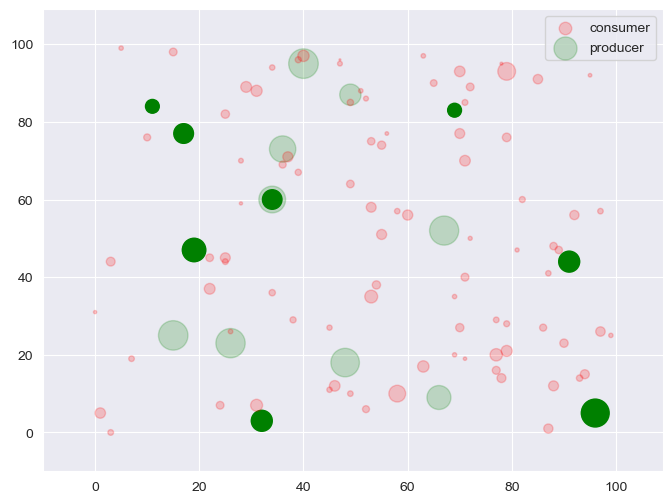

In [10]:
df_nodes["sol"] = model.p.extract_values()
ShowInstance(df_nodes)

## Sensitivity analysis 
Next, we will study the sensitivity of the optimal solution and value to the different risk guarantee levels - this helps the decision maker find a level that offers the best risk-reward tradeoff. To this end, we solve the same MILO varying the values first of $\varepsilon \in [0, 1]$ (for fixed $\Delta=1000$) and then of $\Delta \in [0, 2000]$ (for fixed $\varepsilon = 0.02$).     

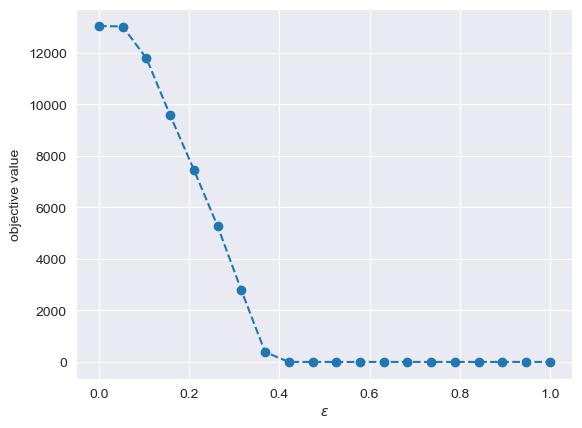

In [11]:
import logging

# don't log pyomo warning messages
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

fixed_Delta = 1000

feas_eps = []
feas_objs = []

eps = 0
model = economic_dispatch(nodes, wind_production_samples, eps, fixed_Delta)

for eps in np.linspace(0, 1, num=20):
    model.eps = eps
    result = pyo.SolverFactory(SOLVER).solve(model)

    if result.solver.termination_condition == "optimal":
        feas_eps.append(eps)
        feas_objs.append(model.objective())

plt.plot(feas_eps, feas_objs, marker="o", linestyle="--")
plt.xlabel("$\epsilon$")
plt.ylabel("objective value")
plt.show()

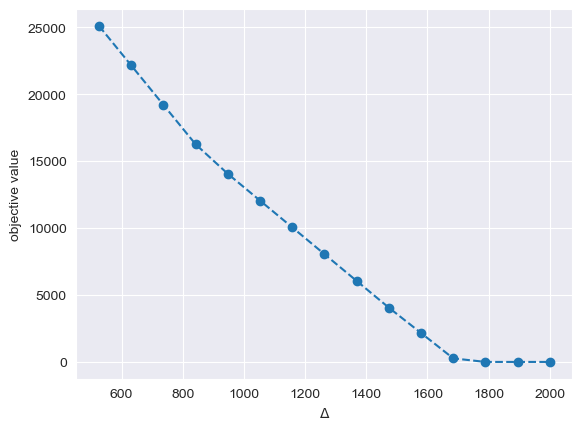

In [12]:
fixed_eps = 0.02

feas_Deltas = []
feas_objs = []

Delta = 0
model = economic_dispatch(nodes, wind_production_samples, fixed_eps, Delta)

for Delta in np.linspace(0, 2000, num=20):
    model.Delta = Delta
    result = pyo.SolverFactory(SOLVER).solve(model)

    if result.solver.termination_condition == "optimal":
        feas_Deltas.append(Delta)
        feas_objs.append(model.objective())

plt.plot(feas_Deltas, feas_objs, marker="o", linestyle="--")
plt.xlabel("$\Delta$")
plt.ylabel("objective value")
plt.show()

Based on the above plots, we can make the following observations:

- Smaller values $\varepsilon$ and $\Delta$ lead to more infeasibilities, which is to be expected. Smaller $\varepsilon$ allow for less constraint violations/relaxations, whereas smaller Delta make constraints tighter (and thus easier to violate).
- The reason why the plot becomes flat for high $\varepsilon$ and $\Delta$ values is because production is no longer needed. For instance, a high $\varepsilon$ means we can ignore the $N\varepsilon$ worst-case sample scenarios, whereas higher $\Delta$ means that we do not need to produce to match demand.